In [1]:
# General use
import pandas as pd
import numpy as np
import os

# Plotting
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Deep learning and metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Activation, Dropout

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data Processing

In [3]:
# from google.colab import drive

# drive.mount('/content/drive') 
# path = os.path.expanduser(f'/content/drive/My Drive/Colab Notebooks/city_traffic_forecasting/')
# df = pd.read_csv(os.path.join(path, 'traffic_data/train_ML_IOT.csv'))
# df_blind = pd.read_csv(os.path.join(path, 'traffic_data/test_ML_IOT.csv'))

Mounted at /content/drive


In [4]:
# Read in the data
df = pd.read_csv(os.path.join(os.getcwd(), "traffic_data", "train_ML_IOT.csv"))
df_blind = pd.read_csv(os.path.join(os.getcwd(), "traffic_data", "test_ML_IOT.csv"))


In [5]:
def processing(df, is_blind=False):
    # if it's a blind set, there's no Vehicles column
    if is_blind:
      # Take out ID column
      df = df.loc[:, ['DateTime', 'Junction']]
    else:
      # Take out ID column
      df = df.loc[:, ['DateTime', 'Junction', 'Vehicles']]

    # Convert date from string to datetime
    df['DateTime'] = pd.to_datetime(df["DateTime"], format="%Y-%m-%d %H:%M:%S")

    # Create year, month, date columns
    df['year'] = df['DateTime'].dt.year
    df['month'] = df['DateTime'].dt.month
    df['date'] = df['DateTime'].dt.day
    # Create weekday. Monday is 0, Sunday is 6
    df['weekday'] = df['DateTime'].dt.weekday
    df.loc[df['weekday']==0,'weekday'] = "Monday"
    df.loc[df['weekday']==1,'weekday'] = "Tuesday"
    df.loc[df['weekday']==2,'weekday'] = "Wednesday"
    df.loc[df['weekday']==3,'weekday'] = "Thursday"
    df.loc[df['weekday']==4,'weekday'] = "Friday"
    df.loc[df['weekday']==5,'weekday'] = "Saturday"
    df.loc[df['weekday']==6,'weekday'] = "Sunday"
    # Create hour column
    df['hour'] = df['DateTime'].dt.hour

    # Divide into different traffic junctions
    df1 = df.loc[df["Junction"]==1, :]
    df2 = df.loc[df["Junction"]==2, :]
    df3 = df.loc[df["Junction"]==3, :]
    df4 = df.loc[df["Junction"]==4, :]

    print("Junction 1:", df1.shape, "; Junction 2:", df2.shape, "; Junction 3:", df3.shape, "; Junction 4:", df4.shape)
    
    return df1, df2, df3, df4


In this notebook, we'll be training and predicting on Junction 1 traffic using LSTM model. We will try other forecasting methods on Junctions 2, 3 ,and 4. 

Unfortunately, the blind data set only has the dates, it doesn't have actual vehicles data of which we can use to compare our model predictions with. So we won't be using the blind data. Rather, we will split the first set of data into train and test sets, and use the test set to evaluate our model.

In [6]:
# Process both train-test and blind data
df1, df2, df3, df4 = processing(df)
df1_blind, df2_blind, df3_blind, df4_blind = processing(df_blind, is_blind=True)


Junction 1: (14592, 8) ; Junction 2: (14592, 8) ; Junction 3: (14592, 8) ; Junction 4: (4344, 8)
Junction 1: (2952, 7) ; Junction 2: (2952, 7) ; Junction 3: (2952, 7) ; Junction 4: (2952, 7)


# Deep Learning

### Plotting Functions

Define functions to plot train and test losses and plot predicted vs actual 

In [39]:
def plot_train_history(history, title, save_path):
    # Take out train and test losses
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # Take number of epochs
    epochs = range(len(loss))

    plt.figure(figsize=(20,5))
    # Plot train and test loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Testing loss')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.legend()

    # Save fig
    plt.savefig(os.path.join(save_path, title+'.png'), bbox_inches='tight')
    plt.show()
    


In [40]:
def plot_predictions(prediction, date_range, title, save_path, actual=None, compare=False):
    fig = plt.figure(figsize=(20,5))
    ax = fig.add_subplot(1,1,1) 

    if compare:
      # Calculate some metrics
      print("MSE of Model prediction:", mean_squared_error(actual, prediction))
      print("MAE of Model prediction:", mean_absolute_error(actual, prediction))
      print("Rsquared of Model prediction:", r2_score(actual, prediction))

      # Plot actual
      plt.plot(date_range,list(actual), label='actual')

    # Plot predictions
    plt.plot(date_range,list(prediction), label="prediction")
    
    # Get ticks every 7 days
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%y'))
    # Prevent plotting scientific notation on axis
    ax.yaxis.get_major_formatter().set_scientific(False)
    
    plt.ylabel('# of Vehicles', fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.title(title, fontsize=18, fontweight='bold')
    plt.legend()
    plt.show()
    
    # Save fig
    fig.savefig(os.path.join(save_path, title+'.png'), bbox_inches='tight')
    


### Feature Engineering

We need to perform several steps of data transformation to our time series before feeding them into the model. 
<br> 1) Standardize the series for faster convergence during training and reduced variance over time
<br>2) Break series into windows for LSTM model. The current window will predict the next window. 
<br>3) Create train and test sets to validate our model after training.
<br>4) Create batches from the train and test sets for training.

In [64]:
# Take the data values and dates
series = df1['Vehicles'].values
dates = df1['DateTime']

#### Setting some feature engineering parameters

Set window size and how far ahead to predict
<br>Here, use the previous 4 weeks to predict the next 4 weeks</br>

In [65]:
past_history = 24*7*4
future_target = 24*7*4

Set point where data is split into train and test; 20% of data used to test

In [66]:
# Set training size and testing size

# Test size is 20% of all data
TEST_SIZE = round(len(series) * .2)

# Split point b/w train and test is the point where the test set begins + past history size
TRAIN_SPLIT = len(series) - (past_history + TEST_SIZE)  
print("Test size:", TEST_SIZE, ', which is', TEST_SIZE/24/30, "months", "; Train Split point:", TRAIN_SPLIT)

Test size: 2918 , which is 4.052777777777778 months ; Train Split point: 11002


#### Perform Feature Engineering

Standardize the data based on mean and std from train set; 0 being the center
<br> We standardize because it'll make training faster and reduce the increasing variance over time </br>

In [67]:
# Get mean
series_train_mean = series[:TRAIN_SPLIT].mean()
# Get std
series_train_std = series[:TRAIN_SPLIT].std()
# Standardize
series = (series-series_train_mean)/series_train_std

print("train_mean:", series_train_mean, "; train_std:", series_train_std)

train_mean: 38.10788947464098 ; train_std: 18.183108255995833


Define a function to break the series into window components, so that we can use the current window to predict the next window. For example, if our series is [1,2,3,4,5,6], and our past history window size and future target window size is 3, then we would use [1,2,3] to predict the next window, which is [4,5,6]. <br>This function will also help us split the data into train and test sets. 

In [68]:
def series_to_windows(dataset, target, start_index, end_index, past_history_size,
                      future_target_size, step, single_step=False):
    # inialize list for x and y
    x = []
    y = []

    # set start_index as the end of the 1st window
    start_index = start_index + past_history_size
    
    # If an end_index is given, the labels will go past that index, 
    # (it'll assume that there's more data past end_index)
    # If no end_index is given, the labels will stop at the end index,
    # because we set the end_index to be len of data - target_size
    if end_index is None:
        end_index = len(dataset) - future_target_size
    
    # i begins at the end of each window and goes all the way to the end_index
    for i in range(start_index, end_index):
        # GET PAST HISTORY (x)
        # indices of values to be pulled for one window
        # if step > 1, we don't have consecutive values for each window
        indices = range(i - past_history_size, i, step)
        
        # Pull values from dataset based on indices
        # Reshape data from (history_size,) to (history_size, 1)
        x.append(np.reshape(dataset[indices], (past_history_size, 1)))

        # GET FUTURE TARGET (y)
        if single_step:
            # if single step, take 1 value after the past history window
            y.append(target[i + future_target_size])
        else:
            # it not single step, take a set of values after the past history window
            # length of set of values is future_target_size
            y.append(target[i:i + future_target_size])
            
    return np.array(x), np.array(y)

Split data into window components for LSTM and also train/test sets

In [69]:
# Split train set
# From Series, train set will go from 0 to TRAIN_SPLIT + future_target
x_train, y_train = series_to_windows(dataset = series, target = series, start_index=0,
                                                 end_index=TRAIN_SPLIT, past_history_size = past_history,
                                                 future_target_size = future_target, step=1)
# Split test set
# From Series, test set will go from TRAIN_SPLIT to end of series
x_test, y_test = series_to_windows(dataset = series, target = series, start_index = TRAIN_SPLIT, 
                                             end_index=None, past_history_size = past_history,
                                             future_target_size = future_target, step=1)

print("x_train:", x_train.shape, '; y_train:', y_train.shape, "; x_test:", x_test.shape, '; y_test:', y_test.shape)

x_train: (10330, 672, 1) ; y_train: (10330, 672) ; x_test: (2246, 672, 1) ; y_test: (2246, 672)


Sanity Check
* x_train shape should be (Train_split_point - past_history, past_history, 1)
* y_train shape should be (Train_split_point - past_history, future_target)
* x_test shape should be (Test_size - future_target, past_history, 1)
* y_test shape should be (Test_size - future_target, future_target)


Create tensorflow friendly data and split into batches. <br> Through hyperparameter tuning, batch size 16 seems to work the best for model (defined in the next section)<br> Our train_data and test_data will be windows data of infinite # of batches, with 16 for each batch size. There should be ~645 and ~140 distinct batches.

In [70]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

# Set random seed for reproducibility
tf.random.set_seed(13)

# Create tensor data sets
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# Shuffle and divide train data into batches
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
# Divide test data into batches
test_data = test_data.batch(BATCH_SIZE).repeat()

# print out number of batches
print("# of distinct training batches:", x_train.shape[0]/BATCH_SIZE, "; # of distinct testing batches:", x_test.shape[0]/BATCH_SIZE)

# of distinct training batches: 645.625 ; # of distinct testing batches: 140.375


### Model

Because our window size is quite large (672), we need many units in each of our LSTM cell to compute. Through hyperparameter tuning, 128 seems to work the best. I've also tried a few 2-layered LSTM models, but they overfitted.

In [71]:
multi_step_model = tf.keras.models.Sequential()


multi_step_model.add(tf.keras.layers.LSTM(128, input_shape=x_train.shape[-2:]))  # , return_sequences=True
# multi_step_model.add(tf.keras.layers.LSTM(4, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse')

Epoch size of 40 works the best from hyperparameter tuning.
<br>steps_per_epoch is how many training batches we go through.
<br>validation_steps is how many testing batches used to predict at each epoch.

In [72]:
EPOCHS = 40

steps_per_epoch=88
validation_steps=22

multi_step_history = multi_step_model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=steps_per_epoch,
                                          validation_data=test_data,
                                         validation_steps=validation_steps) 

Epoch 1/40
88/88 [==============================] - 3s 38ms/step - loss: 0.7447 - val_loss: 1.5549
Epoch 2/40
88/88 [==============================] - 3s 34ms/step - loss: 0.5401 - val_loss: 0.9104
Epoch 3/40
88/88 [==============================] - 3s 34ms/step - loss: 0.4324 - val_loss: 0.8693
Epoch 4/40
88/88 [==============================] - 3s 34ms/step - loss: 0.4008 - val_loss: 0.7960
Epoch 5/40
88/88 [==============================] - 3s 34ms/step - loss: 0.3804 - val_loss: 0.6998
Epoch 6/40
88/88 [==============================] - 3s 34ms/step - loss: 0.3282 - val_loss: 0.6881
Epoch 7/40
88/88 [==============================] - 3s 33ms/step - loss: 0.3137 - val_loss: 0.4478
Epoch 8/40
88/88 [==============================] - 3s 34ms/step - loss: 0.2540 - val_loss: 0.4945
Epoch 9/40
88/88 [==============================] - 3s 34ms/step - loss: 0.2970 - val_loss: 0.4168
Epoch 10/40
88/88 [==============================] - 3s 34ms/step - loss: 0.2232 - val_loss: 0.3884
Epoch 11/

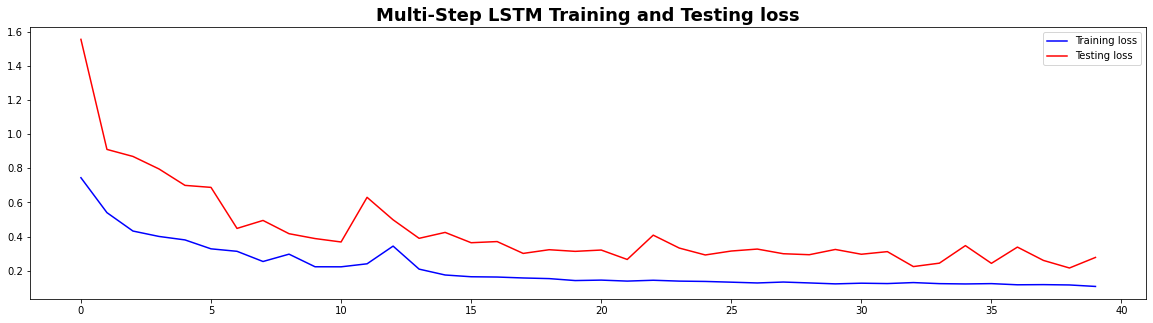

In [74]:
# Plot and save the train and test loss plot
plot_train_history(multi_step_history, 'Multi-Step LSTM Training and Testing loss', save_path=os.path.join(path, 'deep_learning_results'))

In [75]:
# Brief evaluation of the model
multi_step_model.evaluate(x_test, y_test)

71/71 [==============================] - 1s 14ms/step - loss: 0.4817


0.4817098379135132

In [76]:
# Save the model
multi_step_model.save(os.path.join(path,'deep_learning_results','multi_step_model.h5'))

# Can load the model with this
# multi_step_model = tf.keras.models.load_model(os.path.join(path,'deep_learning_results','multi_step_model.h5'))

### Test Set

Predict and analyze results in test set

Function to predict windows, un-standardize the predictions, and combine predictions into a series

In [77]:
def multi_step_predict(x_test_windows, mean, std, past_history_size, future_target_size, model): 
    # Initialize lists to collect predicted y's
    y_pred_list = []
    # For each window, predict future target. Skip days based on future target size
    for i in range(0,x_test_windows.shape[0], future_target_size):

        # Pull out the window and reshape to predict
        x_pred = np.reshape(x_test_windows[i, :, :], (1, past_history_size, 1))
        # Predict and transform back into un-standardized values
        y_pred = model.predict(x_pred)[0]
        y_pred = (y_pred * std) + mean
        y_pred = list(y_pred)
        y_pred_list = y_pred_list + y_pred

    return y_pred_list

Function take in windows of y_test, un-standardize them, and combine them into a series

In [78]:
def transform_y_test(y_test_windows, mean, std, future_target_size):
    # Initialize lists to collect actual y's
    y_test_list = []
    # For each window, predict future target. Skip days based on future target size
    for i in range(0,y_test_windows.shape[0], future_target_size):
        # Pull out the corresponding y values, un-standardize values
        y_test = y_test_windows[i,:]
        y_test = (y_test * std) + mean
        y_test = list(y_test)
        y_test_list = y_test_list + y_test

    return y_test_list


In [79]:
y_predict = multi_step_predict(x_test, series_train_mean, series_train_std, past_history, future_target, multi_step_model)
y_test_transform = transform_y_test(y_test, series_train_mean, series_train_std, future_target)

In [80]:
# Change date range
# dates of predicted y's go from train split point + past history to however long y_predict is
# add past_history because we need that portion to predict first
# it goes to however long y_predict is because the whole length of dates is not evenly divisible by future_target_size. There would be some leftover length
dates_plot = dates[TRAIN_SPLIT + past_history: TRAIN_SPLIT+past_history+len(y_predict)]


MSE of Model prediction: 116.79701926622569
MAE of Model prediction: 7.894791825896218
Rsquared of Model prediction: 0.781689288927


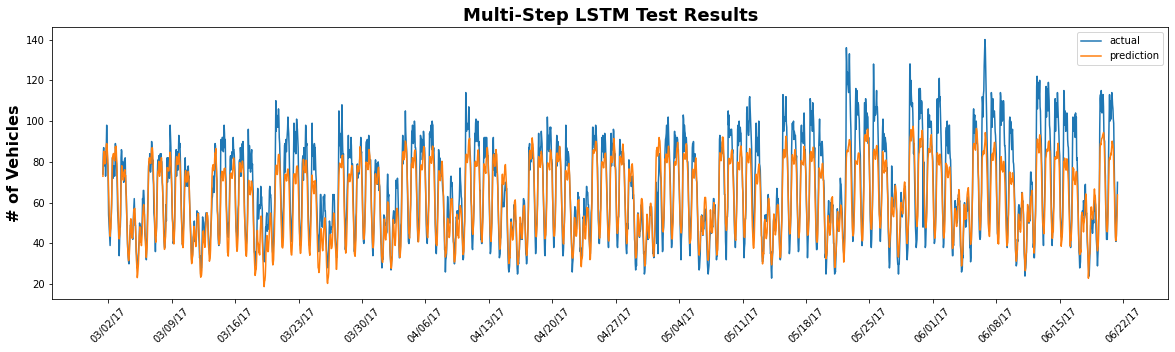

In [81]:
plot_predictions(actual=y_test_transform, prediction=y_predict, date_range=dates_plot,
                 title="Multi-Step LSTM Test Results", save_path=os.path.join(path,'deep_learning_results'), compare=True)


Here, we see that the model performs quite well.
* 78% rsquared value, meaning the model can explain 78% of the variation in the test data.
* 7.89 mean absolute error, meaning on average, the model predition is different from actual by ~8 vehicles.

We also see that for this test set, from March to mid-May, the model performs quite well. However, after mid-May the model tends to underestimate the number of vehicles per hour.

### Predict one window

Unfortunately, the blind data set does not have vehicles data for us to use to predict. So let's predict on the last window of the test set and compare our predictions to a similar period from the previous year.

The last window of our test set goes from **2017-06-03 to 2017-06-30**, so we will use that time range to predict **2017-07-01 to 2017-07-28**. Then, we will compare the predictions with the period **2016-07-01 to 2016-07-28**. Although these are from different years, they are from the same period of the year, and perhaps we can still see some patterns.

In [82]:
# Take Vehicles from the last window of the test set (2017-06-03 to 2017-06-30)
x_blind = x_test[-1, :, :]
# Reshape to (1, past_history, 1)
x_blind = x_blind[np.newaxis,:,:]
# Predict
y_blind_pred = multi_step_model.predict(x_blind)[0]
# Un-standardize the predictions
y_blind_pred = (y_blind_pred * series_train_std) + series_train_mean

# Get the dates range of the predictions (2017-07-01 to 2017-07-28)
dates_plot_blind = df1_blind["DateTime"].values[:future_target]  

# Get the 2016 data to compare (2016-07-01 to 2016-07-28)
y_blind = df1.loc[(df1['DateTime']>='2016-07-01 00:00:00') & (df1['DateTime']<='2016-07-28 23:00:00'), 'Vehicles']

MSE of Model prediction: 622.1945222447315
MAE of Model prediction: 21.62219360045024
Rsquared of Model prediction: -1.6268850290261185


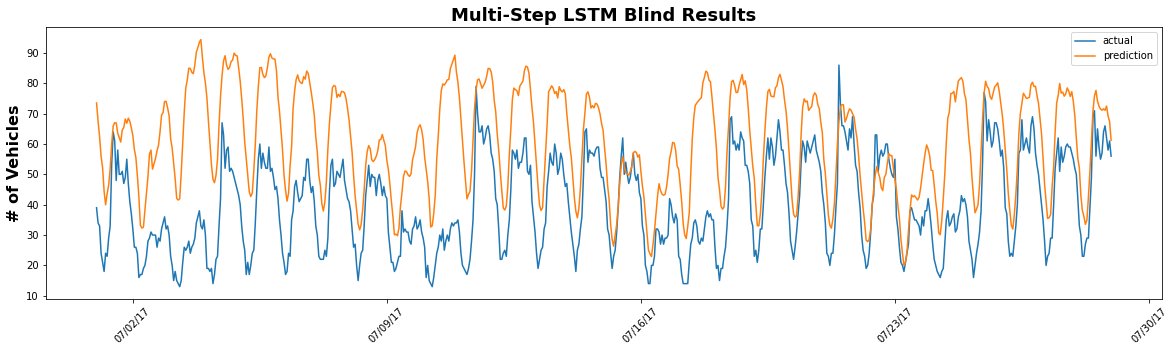

In [83]:
plot_predictions(actual=y_blind, prediction=y_blind_pred, date_range=dates_plot_blind,
                 title="Multi-Step LSTM Blind Results", save_path=os.path.join(path,'deep_learning_results'), compare=True)

Here, we see our rsquared value is -1.63, which is definitely not good since rsquared should range from 0 to 1. For this set of data, the rsquared indicates that our model performs worse than a horizontal line. Looking at the plot, we see that the model underestimates the majority of the number of vehicles in this time frame. 

However, we also see that the model predicts the daily traffic pattern quite well, with decreases in traffic during night time and weekends, and increase during daytime and weekdays. And considering that the comparison data is from a different year, and the mean absolute error is 21.62 (average difference in # of vehicles between the model and the 2016 data), the model seems to have some basic patterns down for predicting traffic every 4 weeks.